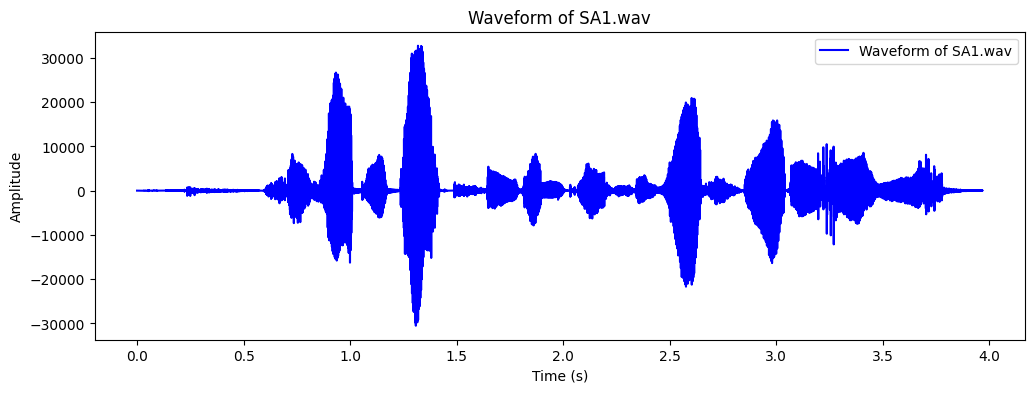

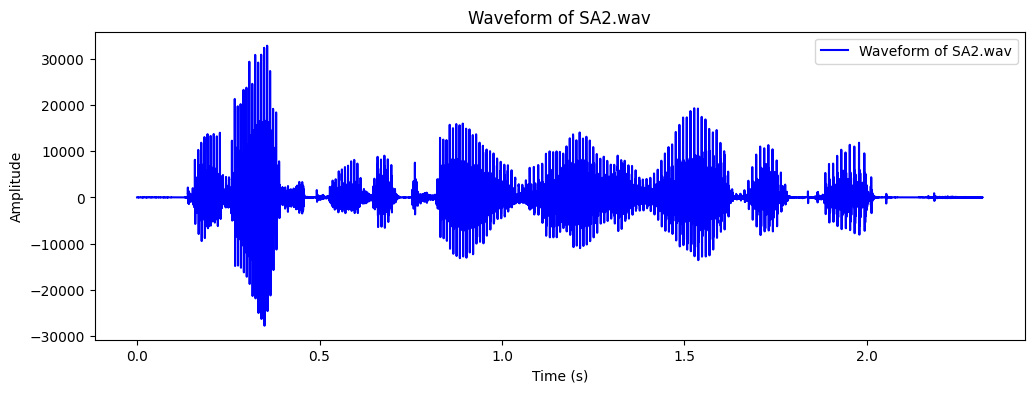

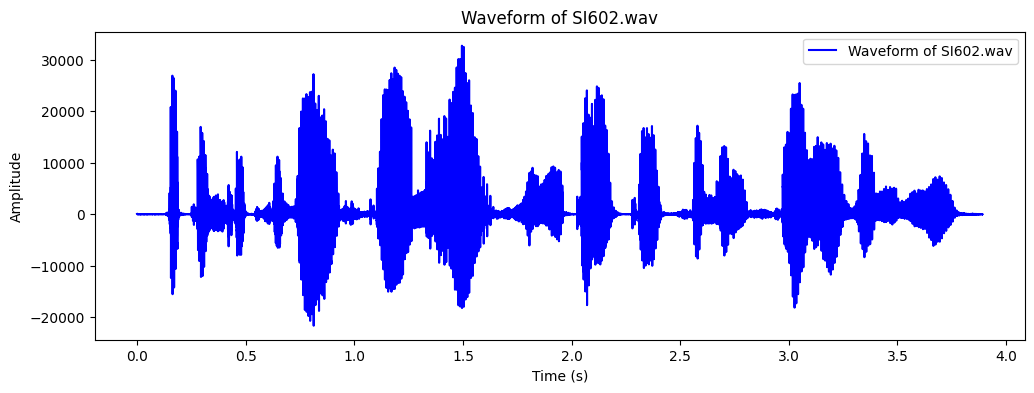

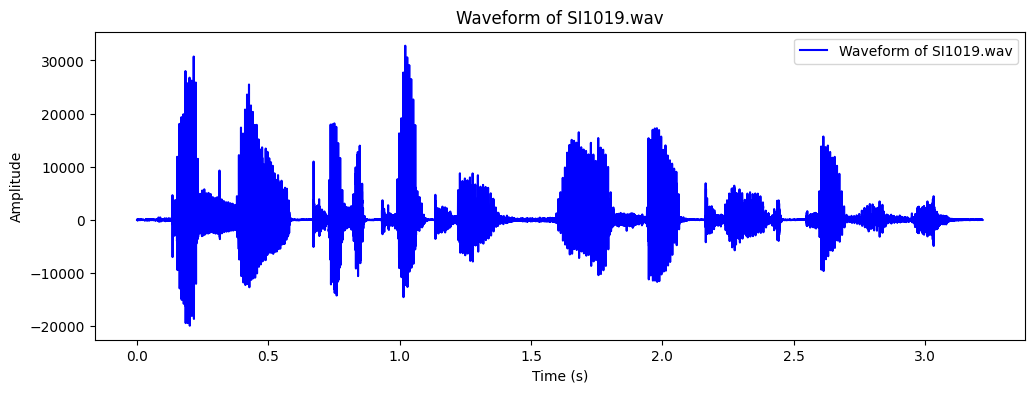

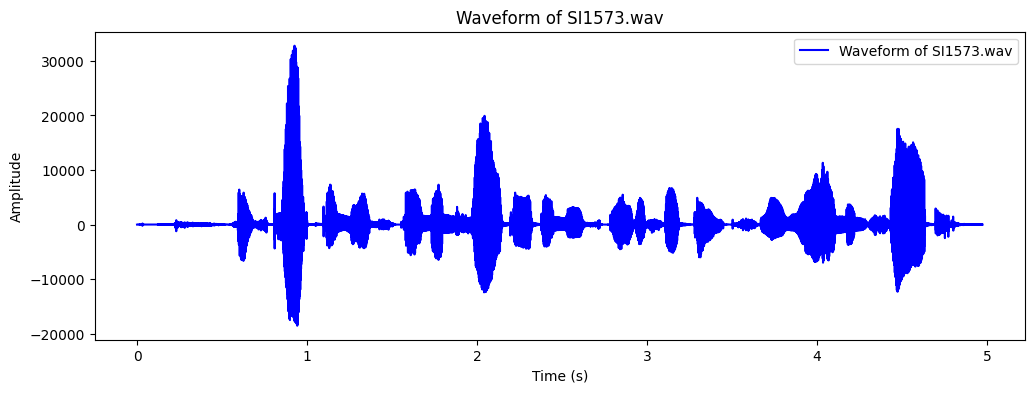

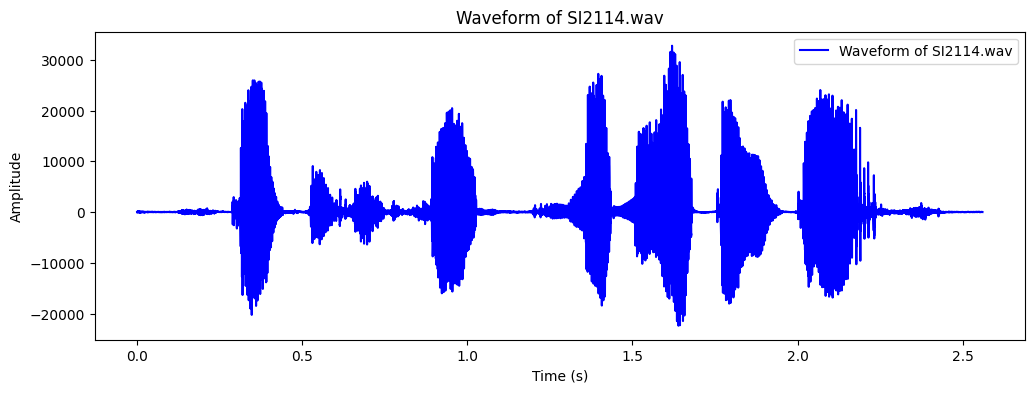

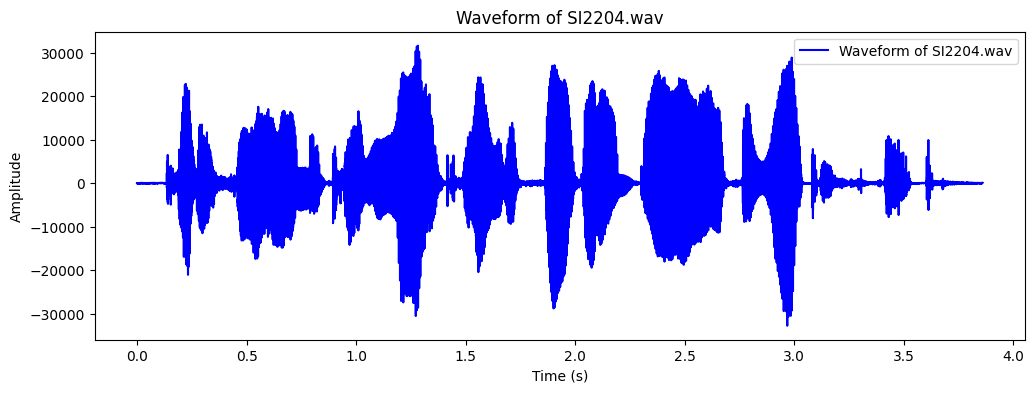

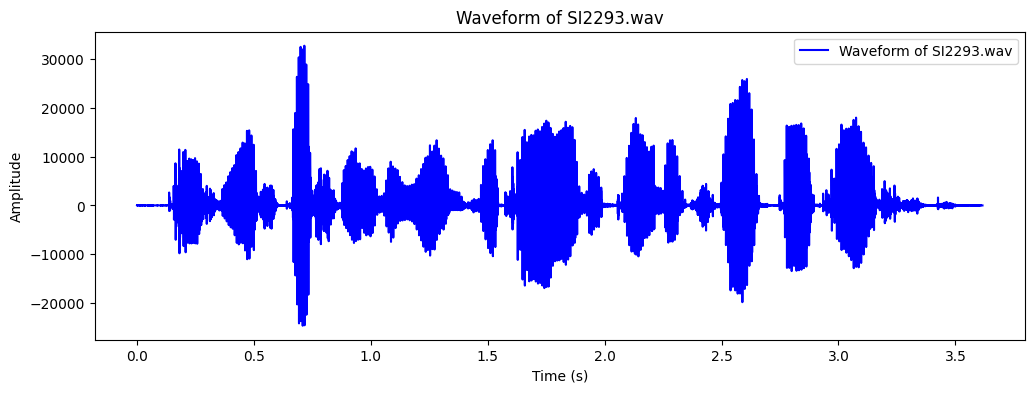

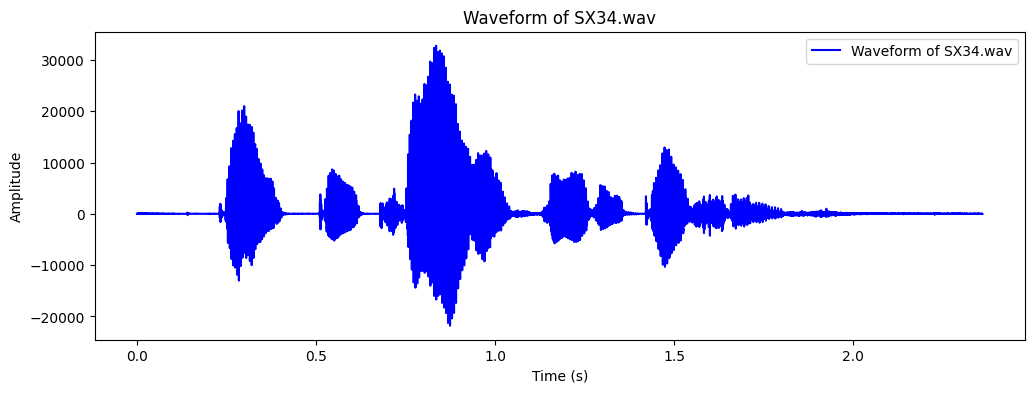

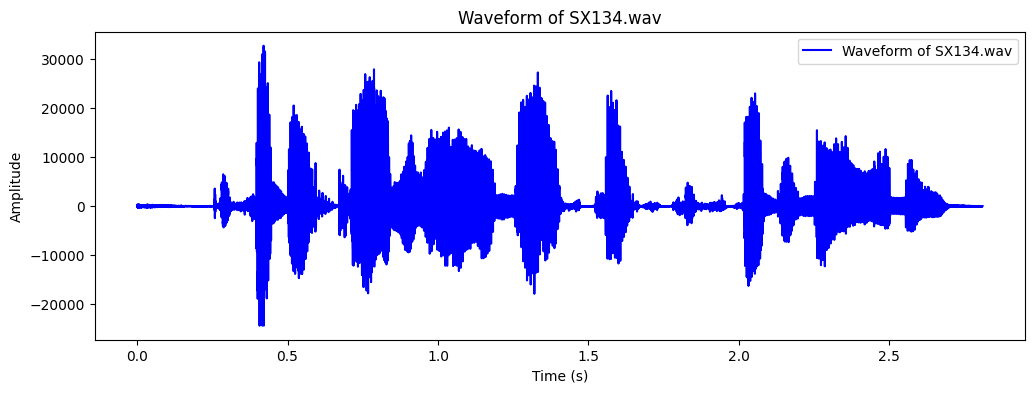

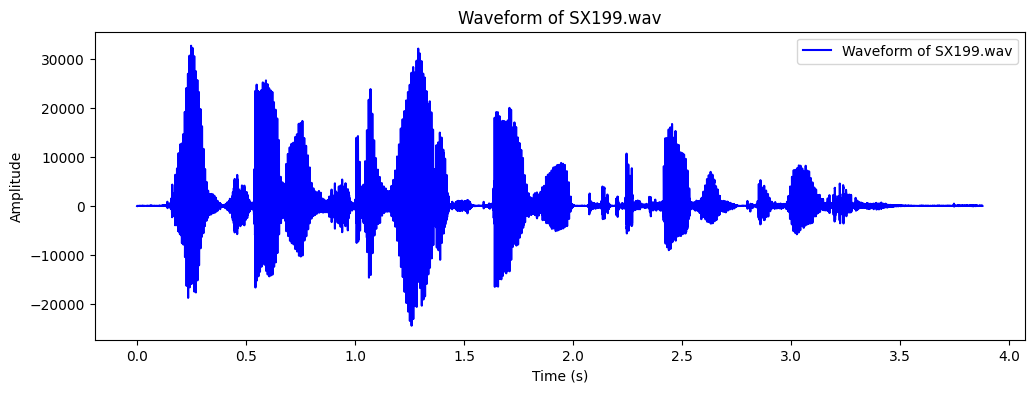

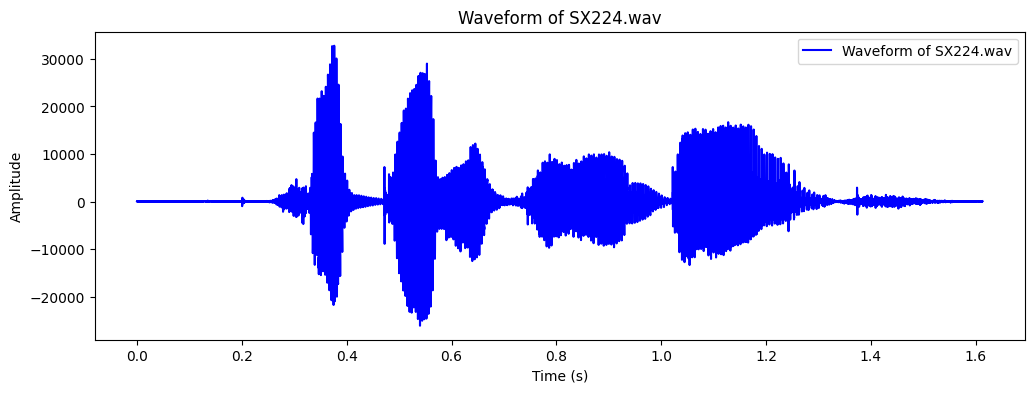

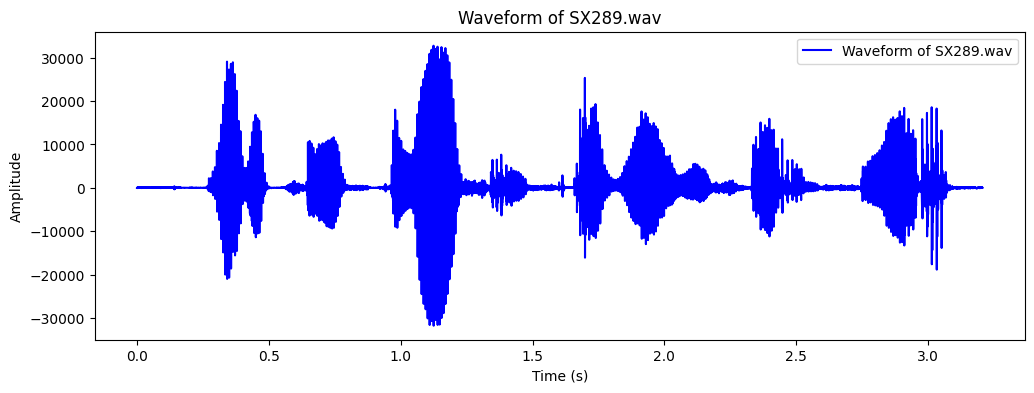

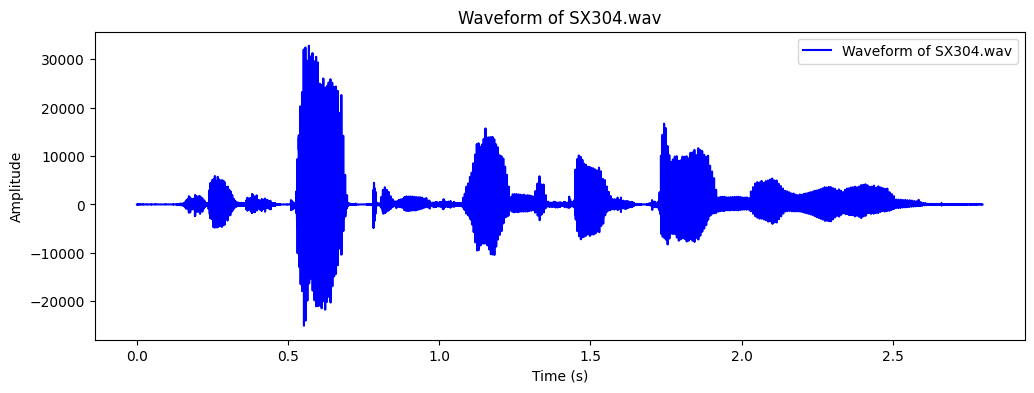

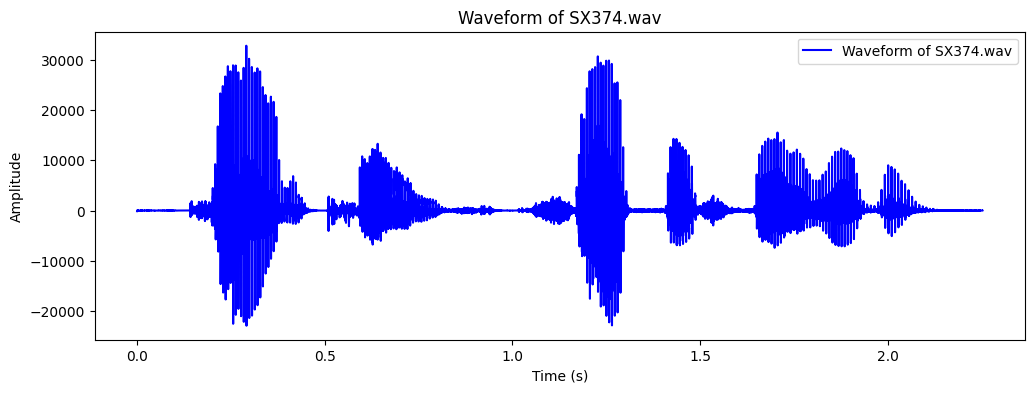

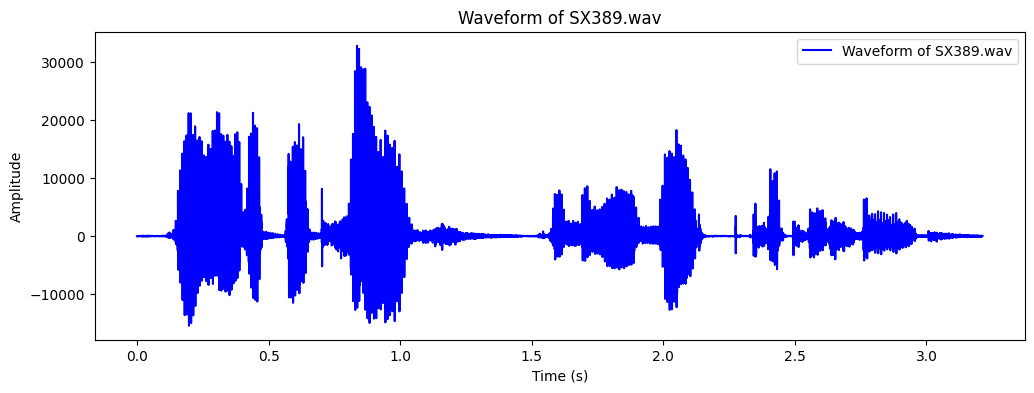

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

audio_files = ["SA1.wav", "SA2.wav", "SI602.wav", "SI1019.wav", "SI1573.wav", "SI2114.wav", "SI2204.wav", "SI2293.wav", "SX34.wav", "SX134.wav", "SX199.wav", "SX224.wav", "SX289.wav", "SX304.wav", "SX374.wav", "SX389.wav", ]

audio_data = {}

for file in audio_files:
    sr, y = wavfile.read(file)
    audio_data[file] = (sr, y)

    duration = float(len(y)) / float(sr)

    plt.figure(figsize=(12, 4))
    plt.plot(np.linspace(0, duration, len(y)), y, label=f"Waveform of {file}", color='b')
    plt.title(f"Waveform of {file.split('/')[-1]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


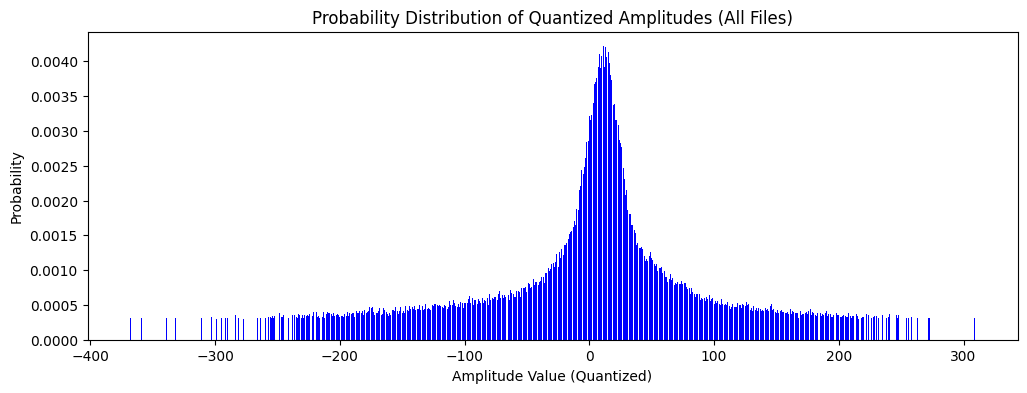

In [2]:
from collections import Counter

all_samples = []

for file, (sr, y) in audio_data.items():
    all_samples.extend(y.astype(np.int16))

symbol_counts = Counter(all_samples)
total_samples = len(all_samples)

symbol_probabilities = {symbol: count / total_samples for symbol, count in symbol_counts.items()}

sorted_probabilities = dict(sorted(symbol_probabilities.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 4))
plt.bar(list(sorted_probabilities.keys())[:500], list(sorted_probabilities.values())[:500], color='b')
plt.xlabel("Amplitude Value (Quantized)")
plt.ylabel("Probability")
plt.title("Probability Distribution of Quantized Amplitudes (All Files)")
plt.show()


In [3]:
import heapq

class Node:
    def __init__(self, symbol, probability):
        self.symbol = symbol
        self.probability = probability
        self.left = None   #down
        self.right = None   #up

    def __lt__(self, other):
        return self.probability < other.probability

def build_huffman_tree(symbol_probabilities):
    heap = [Node(symbol, prob) for symbol, prob in symbol_probabilities.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(None, left.probability + right.probability)
        merged.left = right
        merged.right = left
        heapq.heappush(heap, merged)

    return heap[0]

def generate_huffman_codes(node, code="", huffman_codes={}):
    if node is None:
        return

    if node.symbol is not None:
        huffman_codes[node.symbol] = code

    generate_huffman_codes(node.left, code + "1", huffman_codes)   #down
    generate_huffman_codes(node.right, code + "0", huffman_codes)   #up

    return huffman_codes

huffman_tree = build_huffman_tree(symbol_probabilities)
huffman_codes = generate_huffman_codes(huffman_tree)

top_10_codes = list(huffman_codes.items())[:10]
print("Top 10 Huffman Codes:")
for symbol, code in top_10_codes:
    print(f"Symbol: {symbol}, Huffman Code: {code}")


Top 10 Huffman Codes:
Symbol: 181, Huffman Code: 111111111111
Symbol: 196, Huffman Code: 111111111110
Symbol: -230, Huffman Code: 111111111101
Symbol: 718, Huffman Code: 11111111110011
Symbol: -4597, Huffman Code: 1111111111001011
Symbol: -6180, Huffman Code: 1111111111001010
Symbol: -2831, Huffman Code: 111111111100100
Symbol: -481, Huffman Code: 1111111111000
Symbol: -515, Huffman Code: 1111111110111
Symbol: -683, Huffman Code: 1111111110110


In [4]:

encoded_audio = []

for sample in all_samples:
    encoded_audio.append(huffman_codes[sample])

encoded_bitstream = "".join(encoded_audio)

print("Encoded Bitstream (first 200 bits):")
print(encoded_bitstream[:200])

original_size_bits = len(all_samples) * 16
compressed_size_bits = len(encoded_bitstream)
compression_ratio = original_size_bits / compressed_size_bits

print(f"Original Size: {original_size_bits} bits")
print(f"Compressed Size: {compressed_size_bits} bits")
print(f"Compression Ratio: {compression_ratio:.2f}")


Encoded Bitstream (first 200 bits):
10101101101011010111001010101110011100101000000110011000100000011000000110011000101011010111011010011000011101100010011110101101101011010010111010000001100110001000000110011101010100101010111000001110
Original Size: 6468512 bits
Compressed Size: 5043766 bits
Compression Ratio: 1.28


In [5]:

inverse_huffman_codes = {code: symbol for symbol, code in huffman_codes.items()}

decoded_samples = []
current_code = ""

for bit in encoded_bitstream:
    current_code += bit
    if current_code in inverse_huffman_codes:
        decoded_samples.append(inverse_huffman_codes[current_code])
        current_code = ""

decoded_audio = np.array(decoded_samples, dtype=np.int16)

output_wavfile = "decoded_audio.wav"
wavfile.write(output_wavfile, sr, decoded_audio)

print(f"Decoded audio samples: {len(decoded_audio)}")
print(f"Original audio samples: {len(all_samples)}")

reconstruction_error = np.mean((decoded_audio - np.array(all_samples, dtype=np.int16)) ** 2)
print(f"Reconstruction Error (MSE): {reconstruction_error:.2f}")


Decoded audio samples: 404282
Original audio samples: 404282
Reconstruction Error (MSE): 0.00


Signal-to-Noise Ratio (SNR): inf dB


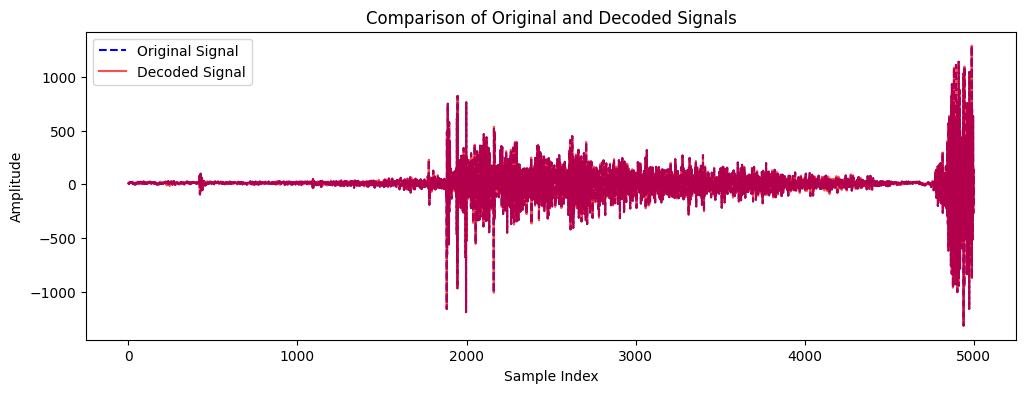

In [6]:

original_signal = np.array(all_samples, dtype=np.int16)
decoded_signal = np.array(decoded_audio, dtype=np.int16)

signal_power = np.mean(original_signal ** 2)
noise_power = np.mean((original_signal - decoded_signal) ** 2)

snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')

print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")

plt.figure(figsize=(12, 4))
plt.plot(original_signal[:5000], label="Original Signal", linestyle='dashed', color='b')
plt.plot(decoded_signal[:5000], label="Decoded Signal", linestyle='solid', color='r', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Comparison of Original and Decoded Signals")
plt.legend()
plt.show()


In [7]:

from collections import Counter
import numpy as np
import heapq

paired_samples = [(all_samples[i], all_samples[i+1]) for i in range(0, len(all_samples) - 1, 2)]

symbol_counts_paired = Counter(paired_samples)
total_pairs = len(paired_samples)
symbol_probabilities_paired = {symbol: count / total_pairs for symbol, count in symbol_counts_paired.items()}

class Node:
    def __init__(self, symbol, prob):
        self.symbol = symbol
        self.probability = prob
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.probability < other.probability

def build_huffman_tree(probabilities):
    heap = [Node(sym, prob) for sym, prob in probabilities.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = Node(None, left.probability + right.probability)
        merged.left = right
        merged.right = left
        heapq.heappush(heap, merged)
    return heap[0]

def generate_huffman_codes(node, code="", codebook={}):
    if node is None:
        return
    if node.symbol is not None:
        codebook[node.symbol] = code
    generate_huffman_codes(node.left, code + "1", codebook)
    generate_huffman_codes(node.right, code + "0", codebook)
    return codebook

huffman_tree_paired = build_huffman_tree(symbol_probabilities_paired)
huffman_codes_paired = generate_huffman_codes(huffman_tree_paired, code="", codebook={})

encoded_audio_paired = [huffman_codes_paired[pair] for pair in paired_samples]
encoded_bitstream_paired = ''.join(encoded_audio_paired)

original_bits = len(all_samples) * 16
compressed_bits_paired = len(encoded_bitstream_paired)
compression_ratio_paired = original_bits / compressed_bits_paired
top_10_codes_paired = list(huffman_codes_paired.items())[:10]
print("Top 10 Huffman Codes:")
for symbol, code in top_10_codes_paired:
    print(f"Symbol: {symbol}, Huffman Code: {code}")


print("==== Pairwise Huffman Coding Result ====")
print(f"Total paired symbols: {len(paired_samples)}")
print(f"Huffman Table Size (Paired): {len(huffman_codes_paired)}")
print(f"Huffman Table Size (Original): {len(huffman_codes)}")
print(f"Original size: {original_bits} bits")
print(f"Compressed size (paired symbols): {compressed_bits_paired} bits")
print(f"Compression Ratio (Paired Symbols): {compression_ratio_paired:.2f}")



Top 10 Huffman Codes:
Symbol: (-293, -175), Huffman Code: 111111111111111111
Symbol: (6620, 1541), Huffman Code: 111111111111111110
Symbol: (60, 16), Huffman Code: 111111111111111101
Symbol: (118, 18), Huffman Code: 111111111111111100
Symbol: (-2280, 13914), Huffman Code: 111111111111111011
Symbol: (14192, 4590), Huffman Code: 111111111111111010
Symbol: (220, 87), Huffman Code: 111111111111111001
Symbol: (29, 200), Huffman Code: 111111111111111000
Symbol: (-753, -514), Huffman Code: 111111111111110111
Symbol: (1404, 1351), Huffman Code: 111111111111110110
==== Pairwise Huffman Coding Result ====
Total paired symbols: 202141
Huffman Table Size (Paired): 173688
Huffman Table Size (Original): 26938
Original size: 6468512 bits
Compressed size (paired symbols): 3478485 bits
Compression Ratio (Paired Symbols): 1.86


MSE：0.00
SNR：inf dB


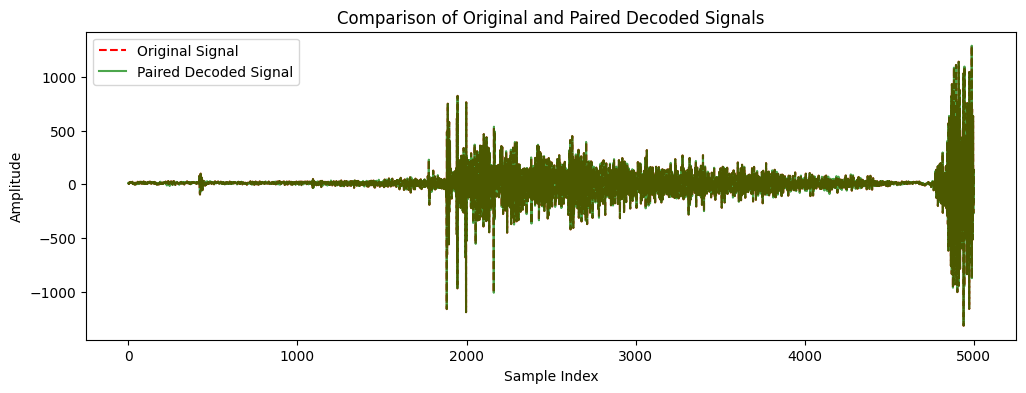

In [10]:
inverse_huffman_codes_paired = {code: symbol for symbol, code in huffman_codes_paired.items()}

decoded_pairs = []
buffer = ""
for bit in encoded_bitstream_paired:
    buffer += bit
    if buffer in inverse_huffman_codes_paired:
        decoded_pairs.append(inverse_huffman_codes_paired[buffer])
        buffer = ""
decoded_samples_flat = []

for pair in decoded_pairs:
    if isinstance(pair, tuple):
        decoded_samples_flat.extend(pair)
    else:
        decoded_samples_flat.append(pair)

decoded_samples_flat = np.array(decoded_samples_flat, dtype=np.int16)

output_wavfile_paired = "decoded_audio_paired.wav"
wavfile.write(output_wavfile_paired, sr, decoded_samples_flat)

reconstruction_error = np.mean((decoded_samples_flat - original_signal) ** 2)
signal_power = np.mean(original_signal ** 2)
noise_power = np.mean((original_signal - decoded_samples_flat) ** 2)
snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')

print(f"MSE：{reconstruction_error:.2f}")
print(f"SNR：{snr:.2f} dB")
plt.figure(figsize=(12, 4))
plt.plot(original_signal[:5000], label="Original Signal", linestyle='dashed', color='r')
plt.plot(decoded_samples_flat[:5000], label="Paired Decoded Signal", linestyle='solid', color='g', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Comparison of Original and Paired Decoded Signals")
plt.legend()
plt.show()


In [9]:
import random
import reedsolo

rs = reedsolo.RSCodec(10)

def encode_with_rs_bits(encoded_bitstream):

    bit_chunks = [encoded_bitstream[i:i+8] for i in range(0, len(encoded_bitstream), 8)]

    if len(bit_chunks[-1]) < 8:
        bit_chunks[-1] = bit_chunks[-1].ljust(8, '0')

    byte_data = bytearray([int(chunk, 2) for chunk in bit_chunks])
    rs_encoded_bytes = rs.encode(byte_data)


    rs_encoded_bitstream = ''.join(f"{byte:08b}" for byte in rs_encoded_bytes)

    return rs_encoded_bitstream

def introduce_error_bits(bitstream, num_errors=5):

    bitstream = list(bitstream)

    for _ in range(num_errors):
        error_index = random.randint(0, len(bitstream) - 1)
        bitstream[error_index] = '1' if bitstream[error_index] == '0' else '0'
    return ''.join(bitstream)

def decode_with_rs_bits(rs_encoded_bitstream):

    bit_chunks = [rs_encoded_bitstream[i:i+8] for i in range(0, len(rs_encoded_bitstream), 8)]

    byte_data = bytearray([int(chunk, 2) for chunk in bit_chunks])

    try:
        corrected_bytes = rs.decode(byte_data)

        corrected_bitstream = ''.join(f"{byte:08b}" for byte in byte_data)

        return corrected_bitstream
    except reedsolo.ReedSolomonError:


        return None

rs_encoded_bitstream = encode_with_rs_bits(encoded_bitstream)
print(f"Original Encoded Bitstream Length: {len(encoded_bitstream)} bits")
print(f"Reed-Solomon Encoded Bitstream Length: {len(rs_encoded_bitstream)} bits")

corrupted_bitstream = introduce_error_bits(rs_encoded_bitstream, num_errors=5)

corrected_bitstream = decode_with_rs_bits(corrupted_bitstream)


Original Encoded Bitstream Length: 5043766 bits
Reed-Solomon Encoded Bitstream Length: 5249688 bits
